# CS 598 Project: Part I - SVM Model Evaluation
## Alexander Asilador. 11/02/2020

Previously, I have tried to use a GAM to predict the angle in the z-axis (i.e. theta_z). This time I will try to perform the task with SVM. Here, I will use a soft-margin kernel svm with a radial basis kernel. This type of model was used in my Problem Set 3 pool detection problem with some success. 

update: 11/02/2020 - I noticed that the distance sensors can be orders of magnitudes higher than the force sensors. To remedy this issue, I took the natural logarithm of each distance sensor. In addition, I added an option to reduce the number of variables by subtracting Fz_r from Fz_l, and subtracting Fx_r from Fx_l.

update: 11/06/2020 - Using Momentum-based model substitute force sensors. First ask if you can predict theta_y instead of theta_z

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import math
import pandas as pd
from scipy import signal

### Load all the data

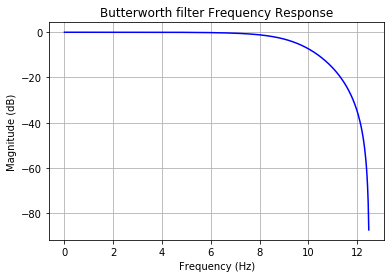

In [2]:
#Make a Butterworth filter with a 1 Hz cutoff
fs = 25
Wn= 9 #critical point 1 Hz
butter_b,butter_a = signal.iirfilter(N=2, Wn=Wn, btype='lowpass',ftype='butter',fs=25,output='ba') #will use a zero-phase filtering to double the order
#signal.filtfilt
w,h = signal.freqz(b=butter_b, a=butter_a, worN=None, whole=False, plot=None);
fig=plt.figure()
freq = w*fs/(2*math.pi);
plt.plot(freq, 20 * np.log10(abs(h)), 'b');
plt.title('Butterworth filter Frequency Response')
plt.xlabel('Frequency (Hz)')
plt.ylabel('Magnitude (dB)')
plt.grid('on')
plt.show()

In [3]:
"""""
def readdata(datadir,foldername,datenm,l=True,collapse=True,filt=True, b=butter_b,a=butter_a):
    tmpstr = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_fdss_final_data.txt"
    tmpstr2 = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_qtm_final_data.txt"
    tmpdata = pd.read_csv(tmpstr)
    #filter before log
    if filt:
        tmpdata['Far left distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Far left distance sensor (mm)'])
        tmpdata['Center left distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Center left distance sensor (mm)'])
        tmpdata['Center right distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Center right distance sensor (mm)'])
        tmpdata['Far right distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Far right distance sensor (mm)'])
    
    if l:
        tmpdata['Far left distance sensor (mm)']=np.log(tmpdata['Far left distance sensor (mm)'])
        tmpdata['Center left distance sensor (mm)']=np.log(tmpdata['Center left distance sensor (mm)'])
        tmpdata['Center right distance sensor (mm)']=np.log(tmpdata['Center right distance sensor (mm)'])
        tmpdata['Far right distance sensor (mm)']=np.log(tmpdata['Far right distance sensor (mm)'])
    
    
    if collapse:
        #Collapse Fz and Fx data to remove highly correlated variables
    
        tmpdata['FzLnet']= tmpdata['Fz left (kg)']-tmpdata['Fz right (kg)']
        tmpdata['FxLnet']= tmpdata['Fx left (kg)']-tmpdata['Fx right (kg)']
        
        del tmpdata['Fz left (kg)']
        del tmpdata['Fz right (kg)']
        del tmpdata['Fx left (kg)']
        del tmpdata['Fx right (kg)']
        
    # look only at z axis for now
    tmpdata2 = pd.read_csv(tmpstr2,usecols=["Torso Twist Angle (deg)"])
    return pd.concat([tmpdata, tmpdata2],axis=1)
"""""

'""\ndef readdata(datadir,foldername,datenm,l=True,collapse=True,filt=True, b=butter_b,a=butter_a):\n    tmpstr = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_fdss_final_data.txt"\n    tmpstr2 = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_qtm_final_data.txt"\n    tmpdata = pd.read_csv(tmpstr)\n    #filter before log\n    if filt:\n        tmpdata[\'Far left distance sensor (mm)\']=signal.filtfilt(b,a,tmpdata[\'Far left distance sensor (mm)\'])\n        tmpdata[\'Center left distance sensor (mm)\']=signal.filtfilt(b,a,tmpdata[\'Center left distance sensor (mm)\'])\n        tmpdata[\'Center right distance sensor (mm)\']=signal.filtfilt(b,a,tmpdata[\'Center right distance sensor (mm)\'])\n        tmpdata[\'Far right distance sensor (mm)\']=signal.filtfilt(b,a,tmpdata[\'Far right distance sensor (mm)\'])\n    \n    if l:\n        tmpdata[\'Far left distance sensor (mm)\']=np.log(tmpdata[\'Far left distance sensor (mm)\'])\n        tmpdata[\'Center left distance sensor 

In [4]:
#Experimental: return predicted theta_x and theta_y from the Force-momentum approach
def readdata(datadir,foldername,datenm,pred='y',takelog_dsensor=True, collapsed=False, moment_x=True,moment_y=True,removesensors=False,filt=True, b=butter_b,a=butter_a):
    tmpstr = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_fdss_final_data.txt"
    tmpstr2 = datadir+"/"+foldername+"/leo_"+foldername+"_"+datenm+"_qtm_final_data.txt"
    tmpdata = pd.read_csv(tmpstr)
    #filter before log
    if filt:
        tmpdata['Far left distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Far left distance sensor (mm)'])
        tmpdata['Center left distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Center left distance sensor (mm)'])
        tmpdata['Center right distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Center right distance sensor (mm)'])
        tmpdata['Far right distance sensor (mm)']=signal.filtfilt(b,a,tmpdata['Far right distance sensor (mm)'])
    
    if takelog_dsensor:
        tmpdata['Far left distance sensor (mm)']=np.log(tmpdata['Far left distance sensor (mm)'])
        tmpdata['Center left distance sensor (mm)']=np.log(tmpdata['Center left distance sensor (mm)'])
        tmpdata['Center right distance sensor (mm)']=np.log(tmpdata['Center right distance sensor (mm)'])
        tmpdata['Far right distance sensor (mm)']=np.log(tmpdata['Far right distance sensor (mm)'])
    
    if collapsed:
        tmpdata['DL']=tmpdata['Far left distance sensor (mm)']-tmpdata['Far right distance sensor (mm)']
        tmpdata['DR']=tmpdata['Center left distance sensor (mm)']-tmpdata['Center right distance sensor (mm)']
        
        del tmpdata['Far left distance sensor (mm)']
        del tmpdata['Center left distance sensor (mm)']
        del tmpdata['Far right distance sensor (mm)']
        del tmpdata['Center right distance sensor (mm)']
    if moment_y:
        d1 = 0.19
        d2 = 0.08
        g = 9.81
        if moment_x:
            tmpdata['My']= (tmpdata['Fx left (kg)'] + tmpdata['Fx right (kg)'])*d2*g
        else:
            tmpdata['My']= ((tmpdata['Fz left (kg)'] + tmpdata['Fz right (kg)'])*d1+ (tmpdata['Fx left (kg)'] + tmpdata['Fx right (kg)'])*d2)*g
        #try a part of momentum
        
        del tmpdata['Fx left (kg)']
        del tmpdata['Fx right (kg)']
    if moment_x:
        #Collapse Fz data to obtain theta_x
        d3 = 0.19
        g = 9.81
        tmpdata['Mx']= (tmpdata['Fz right (kg)'] - tmpdata['Fz left (kg)'])*d3*g
        
        del tmpdata['Fz left (kg)']
        del tmpdata['Fz right (kg)']

    if removesensors:
        if collapsed:
            del tmpdata['DL']
            del tmpdata['DR']
        else:
            del tmpdata['Far left distance sensor (mm)']
            del tmpdata['Center left distance sensor (mm)']
            del tmpdata['Far right distance sensor (mm)']
            del tmpdata['Center right distance sensor (mm)']
        if not moment_x:
            del tmpdata['Fz left (kg)']
            del tmpdata['Fz right (kg)']
        if not moment_y:
            del tmpdata['Fz left (kg)']
            del tmpdata['Fz right (kg)']
        
    if pred=='x':
        tmpdata2 = pd.read_csv(tmpstr2,usecols=["Lean Left/Right Angle (deg)"])
    
    if pred=='y':
        tmpdata2 = pd.read_csv(tmpstr2,usecols=["Lean Forward/Backwards Angle (deg)"])
        
    if pred=='z':
        tmpdata2 = pd.read_csv(tmpstr2,usecols=["Torso Twist Angle (deg)"])
        
    return pd.concat([tmpdata, tmpdata2],axis=1)

In [5]:
datadir = "C:/Users/Alex/Box Sync/CS598 - Final Project/Preliminary Data v2/Test_subject_Leo/"
foldername = "test1"
datenm = "10_27_2020"

x = readdata(datadir,foldername,datenm)


In [6]:
x.head()

,Far left distance sensor (mm),Center left distance sensor (mm),Center right distance sensor (mm),Far right distance sensor (mm),My,Mx,Lean Forward/Backwards Angle (deg)
0,4.762171,4.700507,4.634764,4.962843,1.122264,4.175136,-5.386892
1,4.787843,4.691994,4.632544,4.990502,1.098720,4.193775,-5.381879
2,4.751074,4.708508,4.634165,4.969046,1.090872,4.119219,-5.390345
3,4.745392,4.704779,4.665645,4.979896,1.137960,4.063302,-5.387045
4,4.720277,4.666549,4.670318,4.974725,1.137960,3.988746,-5.373021


In [7]:
#plt.plot(x['Far left distance sensor (mm)'])
#plt.plot(x['Center left distance sensor (mm)'])

In [8]:
datadir = "C:/Users/Alex/Box Sync/CS598 - Final Project/Preliminary Data v2/Test_subject_Leo/"
foldername = "test2"
datenm = "10_27_2020"

x2 = readdata(datadir,foldername,datenm)

In [9]:
x2

,Far left distance sensor (mm),Center left distance sensor (mm),Center right distance sensor (mm),Far right distance sensor (mm),My,Mx,Lean Forward/Backwards Angle (deg)
0,4.912720,4.912605,4.624949,4.882775,1.177200,-3.522771,-4.039268
1,4.914108,4.880947,4.610917,4.866046,1.153656,-3.485493,-4.044028
2,4.869979,4.892937,4.588556,4.844654,1.153656,-3.485493,-4.041766
3,4.895358,4.894099,4.599894,4.870482,1.200744,-3.504132,-4.045150
4,4.918746,4.901218,4.596407,4.901353,1.208592,-3.597327,-4.051545
...,...,...,...,...,...,...,...
1724,5.557915,5.549963,5.234164,5.466032,4.379184,-22.758219,6.777651
1725,5.579864,5.566759,5.226752,5.424730,4.496904,-22.459995,6.769129
1726,5.588888,5.557653,5.220003,5.359981,4.614624,-22.497273,6.690455
1727,5.582882,5.536426,5.218412,5.366936,4.591080,-22.348161,6.626792


In [10]:
# start putting svm stuff
# wow, sklearn can do everything!

In [11]:
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR

In [12]:
# train with 1 test with 2
X = x.iloc[:,:-1].values
y = x.iloc[:,-1:].values
# Feature scaling

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
# Fit SVR to the dataset

regressor = SVR(kernel = 'rbf',C=10)
regressor.fit(X, np.ravel(y))


SVR(C=10, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='scale',
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [13]:
x.iloc[:,:-1]

,Far left distance sensor (mm),Center left distance sensor (mm),Center right distance sensor (mm),Far right distance sensor (mm),My,Mx
0,4.762171,4.700507,4.634764,4.962843,1.122264,4.175136
1,4.787843,4.691994,4.632544,4.990502,1.098720,4.193775
2,4.751074,4.708508,4.634165,4.969046,1.090872,4.119219
3,4.745392,4.704779,4.665645,4.979896,1.137960,4.063302
4,4.720277,4.666549,4.670318,4.974725,1.137960,3.988746
...,...,...,...,...,...,...
2313,5.726805,5.609730,5.576084,5.701998,8.813304,19.216809
2314,5.716054,5.613939,5.568467,5.692489,8.883936,19.421838
2315,5.702773,5.610228,5.605636,5.686187,8.687736,19.943730
2316,5.699696,5.612303,5.624446,5.672437,8.562168,21.006153


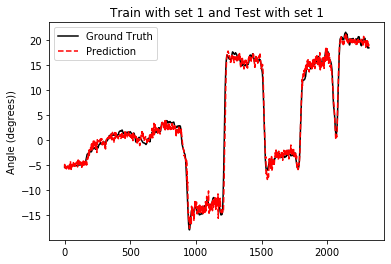

In [14]:
# Sanity check test 1 folder
X = x.iloc[:,:-1].values
X = sc_X.transform(X)
y_pred = regressor.predict(X)
y_pred = sc_y.inverse_transform(y_pred)
y_new = x.iloc[:,-1:].values
plt.figure
plt.plot(y_new,'k-')
plt.plot(y_pred,'r--')
plt.legend(labels=['Ground Truth','Prediction'])
plt.title('Train with set 1 and Test with set 1')
plt.ylabel('Angle (degrees))')
plt.show()

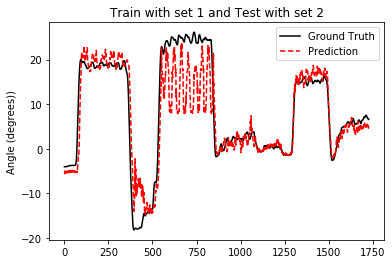

In [15]:
# test 2 folder
X2 = x2.iloc[:,:-1].values
X2 = sc_X.transform(X2)
y_pred = regressor.predict(X2)
y_pred = sc_y.inverse_transform(y_pred)
y_new = x2.iloc[:,-1:].values
plt.figure
plt.plot(y_new,'k-')
plt.plot(y_pred,'r--')
plt.legend(labels=['Ground Truth','Prediction'])
plt.title('Train with set 1 and Test with set 2')
plt.ylabel('Angle (degrees))')
plt.show()

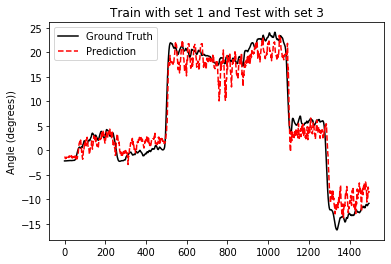

In [16]:
# test 3 folder
foldername = "test3"
x3 = readdata(datadir,foldername,datenm)
X3 = x3.iloc[:,:-1].values
X3 = sc_X.transform(X3)
y_pred = regressor.predict(X3)
y_pred = sc_y.inverse_transform(y_pred)
y_new = x3.iloc[:,-1:].values
plt.figure
plt.plot(y_new,'k-')
plt.plot(y_pred,'r--')
plt.legend(labels=['Ground Truth','Prediction'])
plt.title('Train with set 1 and Test with set 3')
plt.ylabel('Angle (degrees))')
plt.show()

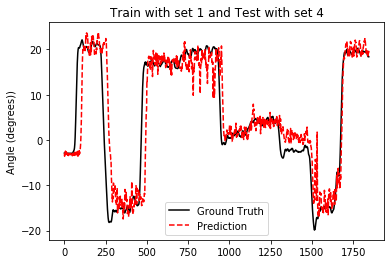

In [17]:
# test 4 folder
foldername = "test4"
x4 = readdata(datadir,foldername,datenm)
X4 = x4.iloc[:,:-1].values
X4 = sc_X.transform(X4)
y_pred = regressor.predict(X4)
y_pred = sc_y.inverse_transform(y_pred)
y_new = x4.iloc[:,-1:].values
plt.figure
plt.plot(y_new,'k-')
plt.plot(y_pred,'r--')
plt.legend(labels=['Ground Truth','Prediction'])
plt.title('Train with set 1 and Test with set 4')
plt.ylabel('Angle (degrees))')
plt.show()

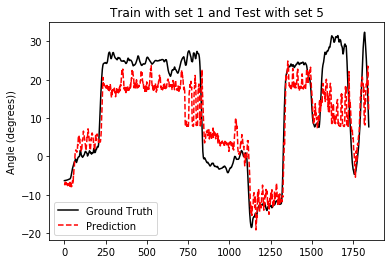

In [18]:
# test 5 folder
foldername = "test5"
x5 = readdata(datadir,foldername,datenm)
X5 = x5.iloc[:,:-1].values
X5 = sc_X.transform(X5)
y_pred = regressor.predict(X5)
y_pred = sc_y.inverse_transform(y_pred)
y_new = x5.iloc[:,-1:].values
plt.figure
plt.plot(y_new,'k-')
plt.plot(y_pred,'r--')
plt.legend(labels=['Ground Truth','Prediction'])
plt.title('Train with set 1 and Test with set 5')
plt.ylabel('Angle (degrees))')
plt.show()

Similar to the results in the GAM implementation. The trained model only seems to do well with itself. It performs horribly for other test sets. Next, I'll try training with 80% of the full set and testing with the remaining 20%

### Train with 80% set and 20% test set

In [19]:
xfull = pd.concat([x, x2, x3, x4, x5], axis=0)

In [20]:
import random

In [21]:
nsamps = xfull.shape[0]
n80p = int(np.floor(nsamps*0.8))
rannums = np.array(random.sample(range(1,nsamps,1), n80p))
s_nfiles = np.arange(nsamps)
test_set = np.setdiff1d(s_nfiles,rannums)

In [22]:
rannums.shape

(7388,)

In [23]:
# train and test
Trainset = xfull.iloc[rannums,:]
Testset = xfull.iloc[test_set,:]

In [24]:
# train with 80% 
X = Trainset.iloc[:,:-1].values
y = Trainset.iloc[:,-1:].values
# Feature scaling

sc_X = StandardScaler()
sc_y = StandardScaler()
X = sc_X.fit_transform(X)
y = sc_y.fit_transform(y)
# Fit SVR to the dataset

In [25]:
regressor = SVR(kernel = 'rbf',shrinking=True,cache_size=300)
from sklearn.model_selection import GridSearchCV
parameters = {'kernel':['rbf'], 'C':[100]} #using broad search for best params
clf = GridSearchCV(regressor, parameters)
#regressor.fit(X, np.ravel(y))
clf.fit(X, np.ravel(y))

GridSearchCV(cv=None, error_score=nan,
             estimator=SVR(C=1.0, cache_size=300, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='scale', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'C': [100], 'kernel': ['rbf']},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring=None, verbose=0)

In [26]:
clf.best_params_

{'C': 100, 'kernel': 'rbf'}

In [27]:
# sanity check with 80% data
Xtrain = Trainset.iloc[:,:-1].values
Xtrain = sc_X.fit_transform(Xtrain)
y_pred = clf.predict(Xtrain)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Trainset.iloc[:,-1:].values

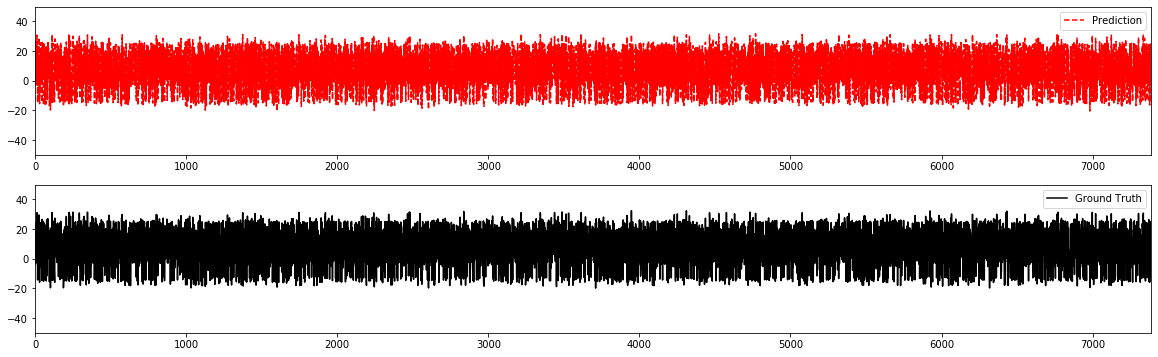

In [28]:
xmin = 0
xmax = Trainset.shape[0]
ymin = -50
ymax = 50

plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.plot(y_pred,'r--')
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Prediction'])
plt.subplot(2,1,2)
plt.plot(y_new,'k-')
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth'])
plt.show()

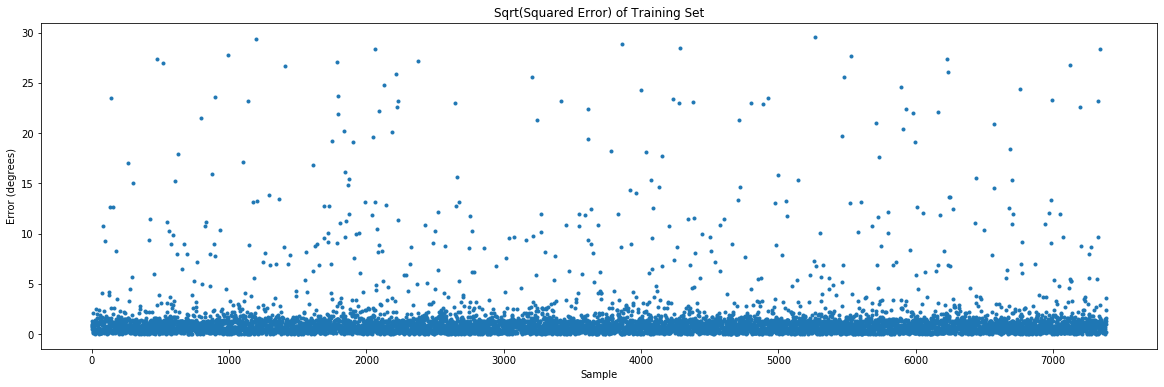

In [29]:
# Squared-root of Squared Error

mse = np.sqrt((y_pred - y_new.reshape(-1))**2)
plt.figure(figsize=(20,6))
plt.plot(mse,'.')
plt.title('Sqrt(Squared Error) of Training Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

In [30]:
# test with 20%
Xtest = Testset.iloc[:,:-1].values
Xtest = sc_X.transform(Xtest)
y_pred = clf.predict(Xtest)
#y_pred = sc_y.inverse_transform(y_pred)
y_pred = sc_y.inverse_transform(y_pred)
y_new = Testset.iloc[:,-1:].values


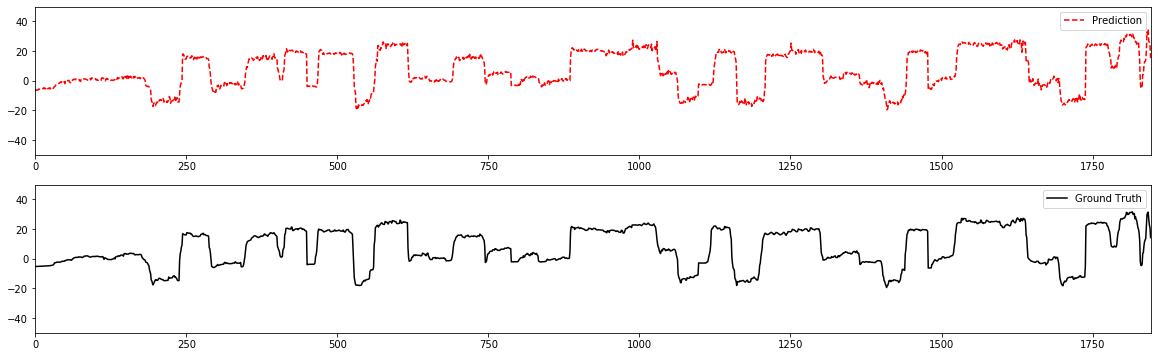

In [31]:
xmin = 0
xmax = Testset.shape[0]
ymin = -50
ymax = 50

plt.figure(figsize=(20,6))
plt.subplot(2,1,1)
plt.plot(y_pred,'r--')
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Prediction'])
plt.subplot(2,1,2)
plt.plot(y_new,'k')
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Ground Truth'])
plt.show()

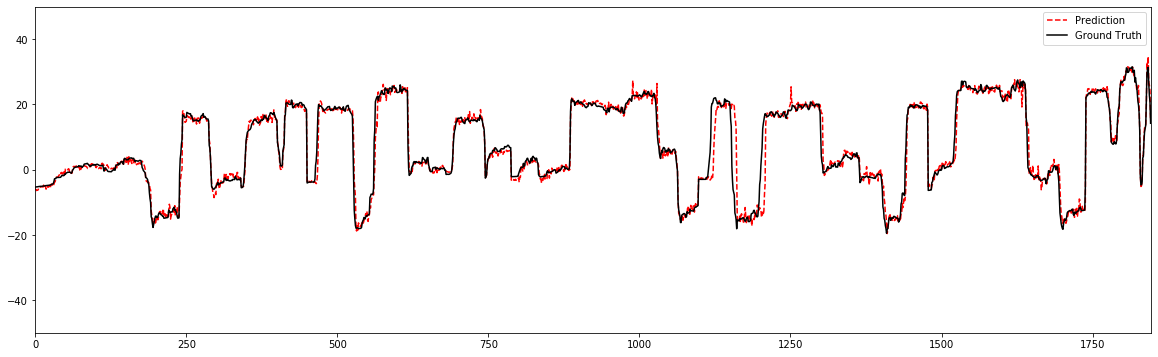

In [32]:
plt.figure(figsize=(20,6))
plt.plot(y_pred,'r--')
plt.plot(y_new,'k')
plt.axis([xmin, xmax, ymin, ymax])
plt.legend(labels=['Prediction','Ground Truth'])
plt.show()

Average error is -0.06 degrees
Root Mean Squared Error is 1.42 degrees


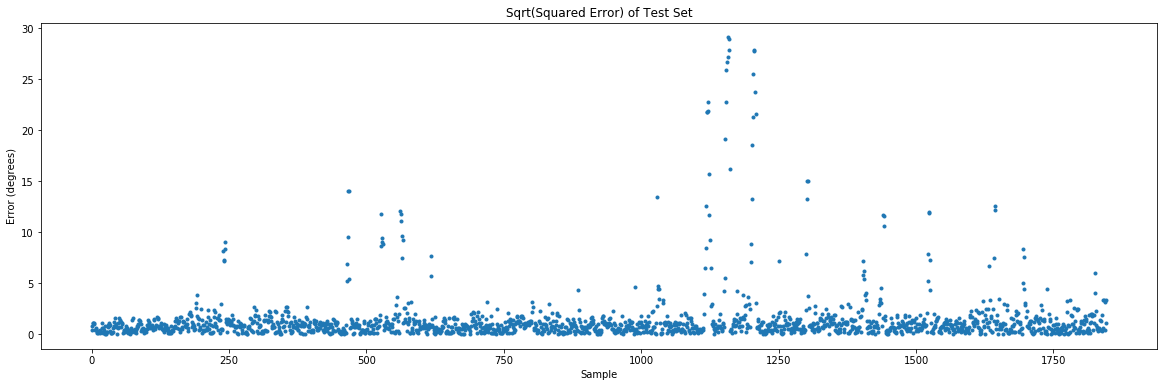

In [33]:
# Squared-root of Squared Error

test_error = (y_pred - y_new.reshape(-1))
print('Average error is {:4.2f} degrees'.format(np.sum(test_error)/test_error.shape[0]))
rmse = np.sqrt(test_error**2)
print('Root Mean Squared Error is {:4.2f} degrees'.format(np.sum(rmse)/test_error.shape[0]))
plt.figure(figsize=(20,6))
plt.plot(rmse,'.')
plt.title('Sqrt(Squared Error) of Test Set')
plt.xlabel('Sample')
plt.ylabel('Error (degrees)')
plt.show()

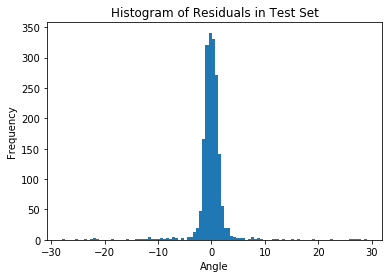

In [34]:
plt.figure()
plt.hist(test_error,bins=100)
plt.title('Histogram of Residuals in Test Set')
plt.xlabel('Angle')
plt.ylabel('Frequency')
plt.show()

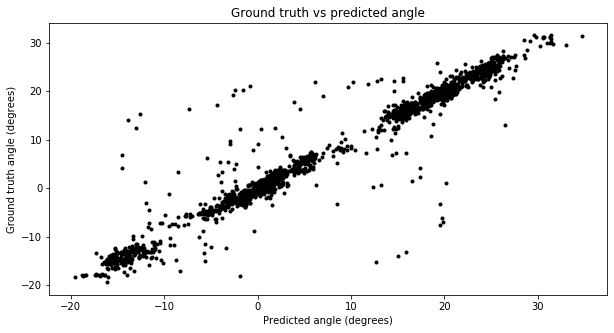

In [35]:
#plot scatterplot of data
plt.figure(figsize=(10,5))
plt.scatter(y_pred,y_new,marker='.',color='black')
plt.xlabel('Predicted angle (degrees)')
plt.ylabel('Ground truth angle (degrees)')
plt.title('Ground truth vs predicted angle')
plt.show()

Even with training for 80% of all data, Kernel SVM still does a poor job at predicting the angle along the z-axis. A kernel SVM is a very powerful tool and I'm surprised that it didn't work as well as I thought it would. Plotting the residuals of the test set show a strong peak at 0 degrees difference, and taper off in a manner similar to a plot seen in y=exp(-|t|). It could very likely be that noise in at least one of the sensors is/are causing erroneous predictions. Something to consider in a later fit is adding a digital filter during the preprocessing step (try a 4th order Lowpass Butterworth filter at 1Hz). Since noise is a big issue, we could try using a Wiener filter. If filtering doesn't work, some other tools that I can try are gradient boosting and Nnet Regression

In [36]:
import pickle

# Save to file in the current working directory
pkl_filename = "svr_thetay_model.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(clf, file)


In [37]:
pkl_filename = "Xsc_thetay.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(sc_X, file)
pkl_filename = "ysc_thetay.pkl"
with open(pkl_filename, 'wb') as file:
    pickle.dump(sc_y, file)

In [38]:
sc_y.n_samples_seen_

7388